The goal of this tutorial is to introduce the twitter Part of Speech tagger and tokenizer - http://www.ark.cs.cmu.edu/TweetNLP/ 

This tutorial has code from https://github.com/brendano/ark-tweet-nlp/
The code is written in Java and the python wrapper for the tokenization and pos tagger are from https://github.com/myleott/ark-twokenize-py and https://github.com/ianozsvald/ark-tweet-nlp-python respectively

Tokenization is the process of separating a piece of text into basic elements such as words, punctuations - tokens. This is often one of the first steps while working with text. 

Part of Speech (POS) tagging involves identifying which part of speech each token belongs to. 
This can be viewed as a task of converting input tokens w1, w2, ....., wn into tags t1, t2, ...., tn.

The 8 common parts of speech for english language are:
1. Noun
2. Verb
3. Pronoun
4. Preposition
5. Adverb
6. Conjuction
7. Participle
8. Article

Twitter data is different from standard language data in that there are tokens such as #, @, emoticons, URLs, etc, that are specific only to twitter. So the tagset for twitter needs to incorporate the tags for these new tokens.
The tags that are used to annotate tweets are as follows:
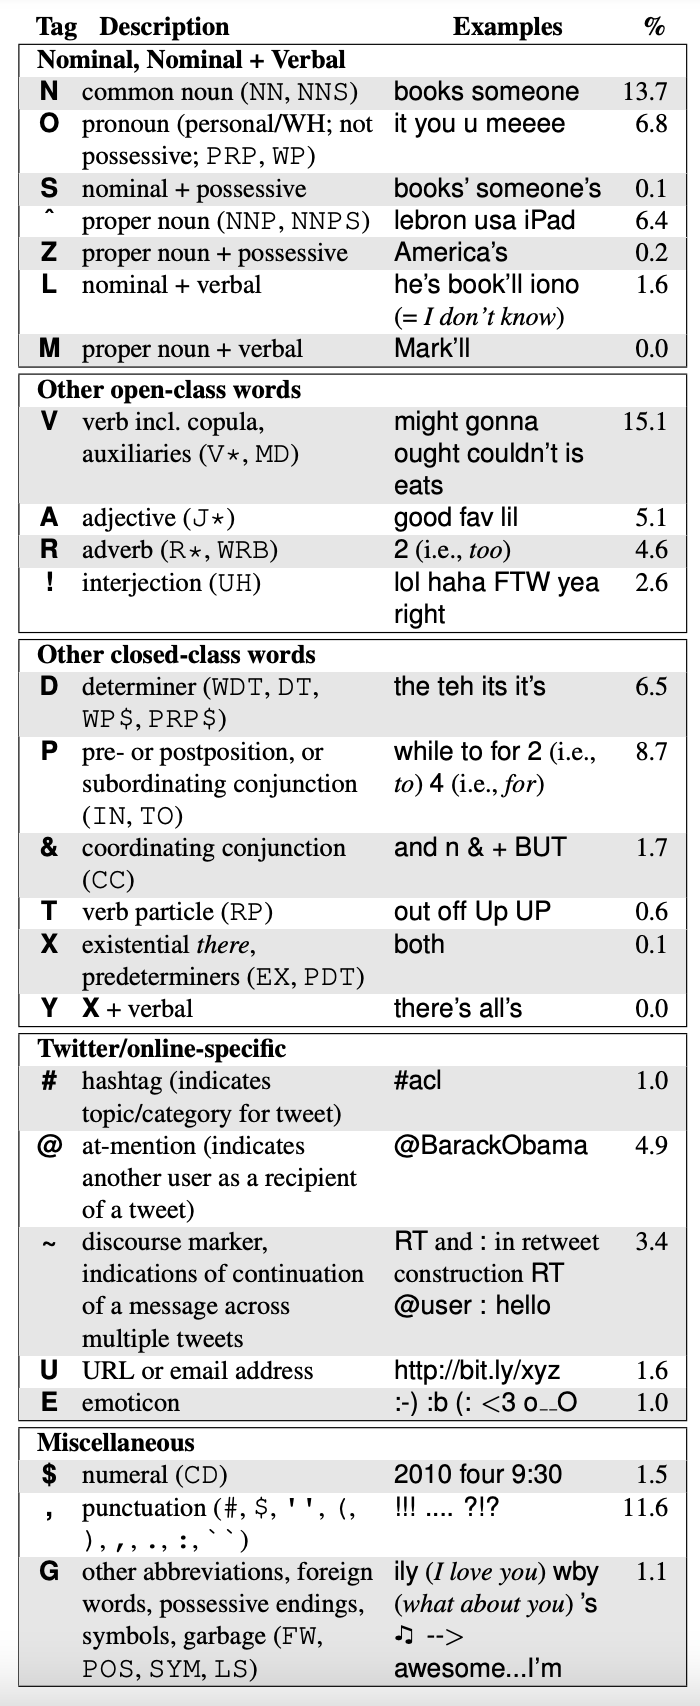

This tutorial covers how to accomplish the task of POS tagging for twitter data based on the paper - https://aclanthology.org/P11-2008.pdf

The nature of twitter data poses challenges in using standard POS taggers. The paper develops a tagset for twitter to include tags for words that are not commonly encountered in natural language outside of twitter. There are around 1800 tweets that were manually annotated with the pos tags. Conditional Random Fields (CRFs) were used with features specific to twitter POS tagging.

The features for the Conditional Random Fields incorporate the following (see paper for more details):
1. Twitter orthography - these features are rules that detect @, #, and URls.
2. Names - these features check for names from a dictionary of compiled tokens which are frequently capitalized.
3. Traditional Tag Dictionary - these are features for all tags that occur in PTB.
4. Distributional Similarity - these features are constructed from the successor and predecessor probabilities for the 10,000 most common terms.
5. Phonetic normalization - words are normalized to ignore alternate spellings of words using the Metaphone algorithm; e.x.{thangs, thanks, thanksss, thanx, thinks, thnx} are mapped to 0NKS.


1827 tweets that are annotated are divided into training set of 1000 tweets, dev set of 327 tweets, and test set of 500 tweets. The results of the tagger incorporating the above features are compared with the standard Stanford Tagger and using the above feature set for twitter data reduces error by about 25%.


To run the tutorial you will need to download the POS tagger from https://code.google.com/archive/p/ark-tweet-nlp/downloads

This requires Java 6. 
https://www.oracle.com/java/technologies/java-platform.html

Place this ipython notebook that has python wrappers inside the ark-tweet-nlp-0.3.2 folder.

The first step would be to download packages required for the notebook.

In [34]:
from __future__ import unicode_literals

import operator
import re
import sys

import subprocess
import shlex

try:
    from html.parser import HTMLParser
except ImportError:
    from HTMLParser import HTMLParser
    

try:
    import html
except ImportError:
    pass  

In [35]:
def regex_or(*items):
    return '(?:' + '|'.join(items) + ')'

Define the expressions to identify punctuation, urls, numeric characters, abbreviations, and emoticons.

In [36]:
Contractions = re.compile(u"(?i)(\w+)(n['’′]t|['’′]ve|['’′]ll|['’′]d|['’′]re|['’′]s|['’′]m)$", re.UNICODE)
Whitespace = re.compile(u"[\s\u0020\u00a0\u1680\u180e\u202f\u205f\u3000\u2000-\u200a]+", re.UNICODE)

punctChars = r"['\"“”‘’.?!…,:;]"
#punctSeq   = punctChars+"+"	#'anthem'. => ' anthem '.
punctSeq   = r"['\"“”‘’]+|[.?!,…]+|[:;]+"	#'anthem'. => ' anthem ' .
entity     = r"&(?:amp|lt|gt|quot);"

#  URLs
# BTO 2012-06: everyone thinks the daringfireball regex should be better, but they're wrong.
# If you actually empirically test it the results are bad.
# Please see https://github.com/brendano/ark-tweet-nlp/pull/9

urlStart1  = r"(?:https?://|\bwww\.)"
commonTLDs = r"(?:com|org|edu|gov|net|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|pro|tel|travel|xxx)"
ccTLDs	 = r"(?:ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|" + \
r"bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|" + \
r"er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|" + \
r"hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|" + \
r"lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|" + \
r"nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|sk|" + \
r"sl|sm|sn|so|sr|ss|st|su|sv|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|" + \
r"va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|za|zm|zw)"	#TODO: remove obscure country domains?
urlStart2  = r"\b(?:[A-Za-z\d-])+(?:\.[A-Za-z0-9]+){0,3}\." + regex_or(commonTLDs, ccTLDs) + r"(?:\."+ccTLDs+r")?(?=\W|$)"
urlBody    = r"(?:[^\.\s<>][^\s<>]*?)?"
urlExtraCrapBeforeEnd = regex_or(punctChars, entity) + "+?"
urlEnd     = r"(?:\.\.+|[<>]|\s|$)"
url        = regex_or(urlStart1, urlStart2) + urlBody + "(?=(?:"+urlExtraCrapBeforeEnd+")?"+urlEnd+")"


# Numeric
timeLike   = r"\d+(?::\d+){1,2}"
#numNum     = r"\d+\.\d+"
numberWithCommas = r"(?:(?<!\d)\d{1,3},)+?\d{3}" + r"(?=(?:[^,\d]|$))"
numComb	 = u"[\u0024\u058f\u060b\u09f2\u09f3\u09fb\u0af1\u0bf9\u0e3f\u17db\ua838\ufdfc\ufe69\uff04\uffe0\uffe1\uffe5\uffe6\u00a2-\u00a5\u20a0-\u20b9]?\\d+(?:\\.\\d+)+%?"

# Abbreviations
boundaryNotDot = regex_or("$", r"\s", r"[“\"?!,:;]", entity)
aa1  = r"(?:[A-Za-z]\.){2,}(?=" + boundaryNotDot + ")"
aa2  = r"[^A-Za-z](?:[A-Za-z]\.){1,}[A-Za-z](?=" + boundaryNotDot + ")"
standardAbbreviations = r"\b(?:[Mm]r|[Mm]rs|[Mm]s|[Dd]r|[Ss]r|[Jj]r|[Rr]ep|[Ss]en|[Ss]t)\."
arbitraryAbbrev = regex_or(aa1, aa2, standardAbbreviations)
separators  = "(?:--+|―|—|~|–|=)"
decorations = u"(?:[♫♪]+|[★☆]+|[♥❤♡]+|[\u2639-\u263b]+|[\ue001-\uebbb]+)"
thingsThatSplitWords = r"[^\s\.,?\"]"
embeddedApostrophe = thingsThatSplitWords+r"+['’′]" + thingsThatSplitWords + "*"

#  Emoticons
# myleott: in Python the (?iu) flags affect the whole expression
#normalEyes = "(?iu)[:=]" # 8 and x are eyes but cause problems
normalEyes = "[:=]" # 8 and x are eyes but cause problems
wink = "[;]"
noseArea = "(?:|-|[^a-zA-Z0-9 ])" # doesn't get :'-(
happyMouths = r"[D\)\]\}]+"
sadMouths = r"[\(\[\{]+"
tongue = "[pPd3]+"
otherMouths = r"(?:[oO]+|[/\\]+|[vV]+|[Ss]+|[|]+)" # remove forward slash if http://'s aren't cleaned

# mouth repetition examples:
# @aliciakeys Put it in a love song :-))
# @hellocalyclops =))=))=)) Oh well

# myleott: try to be as case insensitive as possible, but still not perfect, e.g., o.O fails
#bfLeft = u"(♥|0|o|°|v|\\$|t|x|;|\u0ca0|@|ʘ|•|・|◕|\\^|¬|\\*)".encode('utf-8')
bfLeft = u"(♥|0|[oO]|°|[vV]|\\$|[tT]|[xX]|;|\u0ca0|@|ʘ|•|・|◕|\\^|¬|\\*)"
bfCenter = r"(?:[\.]|[_-]+)"
bfRight = r"\2"
s3 = r"(?:--['\"])"
s4 = r"(?:<|&lt;|>|&gt;)[\._-]+(?:<|&lt;|>|&gt;)"
s5 = "(?:[.][_]+[.])"
# myleott: in Python the (?i) flag affects the whole expression
#basicface = "(?:(?i)" +bfLeft+bfCenter+bfRight+ ")|" +s3+ "|" +s4+ "|" + s5
basicface = "(?:" +bfLeft+bfCenter+bfRight+ ")|" +s3+ "|" +s4+ "|" + s5

eeLeft = r"[＼\\ƪԄ\(（<>;ヽ\-=~\*]+"
eeRight= u"[\\-=\\);'\u0022<>ʃ）/／ノﾉ丿╯σっµ~\\*]+"
eeSymbol = r"[^A-Za-z0-9\s\(\)\*:=-]"
eastEmote = eeLeft + "(?:"+basicface+"|" +eeSymbol+")+" + eeRight

oOEmote = r"(?:[oO]" + bfCenter + r"[oO])"

emoticon = regex_or(
        # Standard version  :) :( :] :D :P
        "(?:>|&gt;)?" + regex_or(normalEyes, wink) + regex_or(noseArea,"[Oo]") + regex_or(tongue+r"(?=\W|$|RT|rt|Rt)", otherMouths+r"(?=\W|$|RT|rt|Rt)", sadMouths, happyMouths),

        # reversed version (: D:  use positive lookbehind to remove "(word):"
        # because eyes on the right side is more ambiguous with the standard usage of : ;
        regex_or("(?<=(?: ))", "(?<=(?:^))") + regex_or(sadMouths,happyMouths,otherMouths) + noseArea + regex_or(normalEyes, wink) + "(?:<|&lt;)?",

        #inspired by http://en.wikipedia.org/wiki/User:Scapler/emoticons#East_Asian_style
        eastEmote.replace("2", "1", 1), basicface,
        # iOS 'emoji' characters (some smileys, some symbols) [\ue001-\uebbb]
        # TODO should try a big precompiled lexicon from Wikipedia, Dan Ramage told me (BTO) he does this

        # myleott: o.O and O.o are two of the biggest sources of differences
        #          between this and the Java version. One little hack won't hurt...
        oOEmote
)

Hearts = "(?:<+/?3+)+" #the other hearts are in decorations

Arrows = regex_or(r"(?:<*[-―—=]*>+|<+[-―—=]*>*)", u"[\u2190-\u21ff]+")

# BTO 2011-06: restored Hashtag, AtMention protection (dropped in original scala port) because it fixes
# "hello (#hashtag)" ==> "hello (#hashtag )"  WRONG
# "hello (#hashtag)" ==> "hello ( #hashtag )"  RIGHT
# "hello (@person)" ==> "hello (@person )"  WRONG
# "hello (@person)" ==> "hello ( @person )"  RIGHT
# ... Some sort of weird interaction with edgepunct I guess, because edgepunct
# has poor content-symbol detection.

# This also gets #1 #40 which probably aren't hashtags .. but good as tokens.
# If you want good hashtag identification, use a different regex.
Hashtag = "#[a-zA-Z0-9_]+"  #optional: lookbehind for \b
#optional: lookbehind for \b, max length 15
AtMention = "[@＠][a-zA-Z0-9_]+"

# I was worried this would conflict with at-mentions
# but seems ok in sample of 5800: 7 changes all email fixes
# http://www.regular-expressions.info/email.html
Bound = r"(?:\W|^|$)"
Email = regex_or("(?<=(?:\W))", "(?<=(?:^))") + r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,4}(?=" +Bound+")"

# We will be tokenizing using these regexps as delimiters
# Additionally, these things are "protected", meaning they shouldn't be further split themselves.
Protected  = re.compile(
    regex_or(
        Hearts,
        url,
        Email,
        timeLike,
        #numNum,
        numberWithCommas,
        numComb,
        emoticon,
        Arrows,
        entity,
        punctSeq,
        arbitraryAbbrev,
        separators,
        decorations,
        embeddedApostrophe,
        Hashtag,
        AtMention), re.UNICODE)

# Edge punctuation
# Want: 'foo' => ' foo '
# While also:   don't => don't
# the first is considered "edge punctuation".
# the second is word-internal punctuation -- don't want to mess with it.
# BTO (2011-06): the edgepunct system seems to be the #1 source of problems these days.
# I remember it causing lots of trouble in the past as well.  Would be good to revisit or eliminate.

# Note the 'smart quotes' (http://en.wikipedia.org/wiki/Smart_quotes)
#edgePunctChars    = r"'\"“”‘’«»{}\(\)\[\]\*&" #add \\p{So}? (symbols)
edgePunctChars    = u"'\"“”‘’«»{}\\(\\)\\[\\]\\*&" #add \\p{So}? (symbols)
edgePunct    = "[" + edgePunctChars + "]"
notEdgePunct = "[a-zA-Z0-9]" # content characters
offEdge = r"(^|$|:|;|\s|\.|,)"  # colon here gets "(hello):" ==> "( hello ):"
EdgePunctLeft  = re.compile(offEdge + "("+edgePunct+"+)("+notEdgePunct+")", re.UNICODE)
EdgePunctRight = re.compile("("+notEdgePunct+")("+edgePunct+"+)" + offEdge, re.UNICODE)

The functions here help in the tokenization of the input tweets, where each token needs to be separated.

In [37]:
def splitEdgePunct(input):
    input = EdgePunctLeft.sub(r"\1\2 \3", input)
    input = EdgePunctRight.sub(r"\1 \2\3", input)
    return input

# The main work of tokenizing a tweet.
def simpleTokenize(text):

    # Do the no-brainers first
    splitPunctText = splitEdgePunct(text)

    textLength = len(splitPunctText)

    # BTO: the logic here got quite convoluted via the Scala porting detour
    # It would be good to switch back to a nice simple procedural style like in the Python version
    # ... Scala is such a pain.  Never again.

    # Find the matches for subsequences that should be protected,
    # e.g. URLs, 1.0, U.N.K.L.E., 12:53
    bads = []
    badSpans = []
    for match in Protected.finditer(splitPunctText):
        # The spans of the "bads" should not be split.
        if (match.start() != match.end()): #unnecessary?
            bads.append( [splitPunctText[match.start():match.end()]] )
            badSpans.append( (match.start(), match.end()) )

    # Create a list of indices to create the "goods", which can be
    # split. We are taking "bad" spans like
    #     List((2,5), (8,10))
    # to create
    #     List(0, 2, 5, 8, 10, 12)
    # where, e.g., "12" here would be the textLength
    # has an even length and no indices are the same
    indices = [0]
    for (first, second) in badSpans:
        indices.append(first)
        indices.append(second)
    indices.append(textLength)

    # Group the indices and map them to their respective portion of the string
    splitGoods = []
    for i in range(0, len(indices), 2):
        goodstr = splitPunctText[indices[i]:indices[i+1]]
        splitstr = goodstr.strip().split(" ")
        splitGoods.append(splitstr)

    #  Reinterpolate the 'good' and 'bad' Lists, ensuring that
    #  additonal tokens from last good item get included
    zippedStr = []
    for i in range(len(bads)):
        zippedStr = addAllnonempty(zippedStr, splitGoods[i])
        zippedStr = addAllnonempty(zippedStr, bads[i])
    zippedStr = addAllnonempty(zippedStr, splitGoods[len(bads)])

    # BTO: our POS tagger wants "ur" and "you're" to both be one token.
    # Uncomment to get "you 're"
    #splitStr = []
    #for tok in zippedStr:
    #    splitStr.extend(splitToken(tok))
    #zippedStr = splitStr

    return zippedStr


def addAllnonempty(master, smaller):
    for s in smaller:
        strim = s.strip()
        if (len(strim) > 0):
            master.append(strim)
    return master

# "foo   bar " => "foo bar"
def squeezeWhitespace(input):
    return Whitespace.sub(" ", input).strip()

# Final pass tokenization based on special patterns
def splitToken(token):
    m = Contractions.search(token)
    if m:
        return [m.group(1), m.group(2)]
    return [token]

# Assume 'text' has no HTML escaping.
def tokenize(text):
    return simpleTokenize(squeezeWhitespace(text))

# Twitter text comes HTML-escaped, so unescape it.
# We also first unescape &amp;'s, in case the text has been buggily double-escaped.
def normalizeTextForTagger(text):
    assert sys.version_info[0] >= 3 and sys.version_info[1] > 3, 'Python version >3.3 required'
    text = text.replace("&amp;", "&")
    text = html.unescape(text)
    return text

# This is intended for raw tweet text -- we do some HTML entity unescaping before running the tagger.
#
# This function normalizes the input text BEFORE calling the tokenizer.
# So the tokens you get back may not exactly correspond to
# substrings of the original text.
def tokenizeRawTweetText(text):
    tokens = tokenize(normalizeTextForTagger(text))
    return tokens

The folder comes with example_tweets.txt, these contain the raw tweets and need to be tokenized before attempting to do the POS tagging.

In [43]:
#file = 'examples/example_tweets.txt'
file = 'examples/new_tweets.txt'

file_object = open(file)
for line in file_object:
    print(' '.join(tokenizeRawTweetText(line)))

I predict I won't win a single game I bet on . Got Cliff Lee today , so if he loses its on me RT @e_one : Texas ( cont ) http://tl.gd/6meogh
@thecamion I like monkeys , but I still hate COSTCO parking lots ..
@DDaimaru I may have to get minecraft after watching videos of it
RT @eye_ee_duh_Esq : LMBO ! This man filed an EMERGENCY Motion for Continuance on account of the Rangers game tonight ! « Wow lmao
RT @musicdenver : Lady Gaga - Bad Romance http://dld.bz/n6Xv
RT @cheriexamor : When you have a good thing , hold it , squeeze it , never let it go .
Texas Rangers are in the World Series ! Go Rangers !!!!!!!!! http://fb.me/D2LsXBJx


In [44]:
file_object = open(file)
tweets = []
for line in file_object:
    tweets.append(' '.join(tokenizeRawTweetText(line)))
    

In [45]:
print(tweets)

["I predict I won't win a single game I bet on . Got Cliff Lee today , so if he loses its on me RT @e_one : Texas ( cont ) http://tl.gd/6meogh", '@thecamion I like monkeys , but I still hate COSTCO parking lots ..', '@DDaimaru I may have to get minecraft after watching videos of it', 'RT @eye_ee_duh_Esq : LMBO ! This man filed an EMERGENCY Motion for Continuance on account of the Rangers game tonight ! « Wow lmao', 'RT @musicdenver : Lady Gaga - Bad Romance http://dld.bz/n6Xv', 'RT @cheriexamor : When you have a good thing , hold it , squeeze it , never let it go .', 'Texas Rangers are in the World Series ! Go Rangers !!!!!!!!! http://fb.me/D2LsXBJx']


The functions below help clean up the tweets and call the runTagger.sh to get the POS tag predictions for the tweets that are tokenized.

In [46]:
RUN_TAGGER_CMD = "java -XX:ParallelGCThreads=2 -Xmx500m -jar ark-tweet-nlp-0.3.2.jar"

def _split_results(rows):
    """Parse the tab-delimited returned lines, modified from: https://github.com/brendano/ark-tweet-nlp/blob/master/scripts/show.py"""
    for line in rows:
        line = line.strip()  # remove '\n'
        if len(line) > 0:
            if line.count('\t') == 2:
                parts = line.split('\t')
                tokens = parts[0]
                tags = parts[1]
                confidence = float(parts[2])
                yield tokens, tags, confidence
                
                
def _call_runtagger(tweets, run_tagger_cmd=RUN_TAGGER_CMD):
    """Call runTagger.sh using a named input file"""

    # remove carriage returns as they are tweet separators for the stdin
    # interface
    tweets_cleaned = [tw.replace('\n', ' ') for tw in tweets]
    message = "\n".join(tweets_cleaned)

    # force UTF-8 encoding (from internal unicode type) to avoid .communicate encoding error as per:
    # http://stackoverflow.com/questions/3040101/python-encoding-for-pipe-communicate
    message = message.encode('utf-8')

    # build a list of args
    args = shlex.split(run_tagger_cmd)
    args.append('--output-format')
    args.append('conll')
    po = subprocess.Popen(args, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    # old call - made a direct call to runTagger.sh (not Windows friendly)
    #po = subprocess.Popen([run_tagger_cmd, '--output-format', 'conll'], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    result = po.communicate(message)
    # expect a tuple of 2 items like:
    # ('hello\t!\t0.9858\nthere\tR\t0.4168\n\n',
    # 'Listening on stdin for input.  (-h for help)\nDetected text input format\nTokenized and tagged 1 tweets (2 tokens) in 7.5 seconds: 0.1 tweets/sec, 0.3 tokens/sec\n')

    pos_result = result[0].decode('utf-8').strip('\n\n')  # get first line, remove final double carriage return
    pos_result = pos_result.split('\n\n')  # split messages by double carriage returns
    pos_results = [pr.split('\n') for pr in pos_result]  # split parts of message by each carriage return
    return pos_results


def runtagger_parse(tweets, run_tagger_cmd=RUN_TAGGER_CMD):
    """Call runTagger.sh on a list of tweets, parse the result, return lists of tuples of (term, type, confidence)"""
    pos_raw_results = _call_runtagger(tweets, run_tagger_cmd)
    pos_result = []
    for pos_raw_result in pos_raw_results:
        pos_result.append([x for x in _split_results(pos_raw_result)])
    return pos_result


def check_script_is_present(run_tagger_cmd=RUN_TAGGER_CMD):
    """Simple test to make sure we can see the script"""
    success = False
    try:
        args = shlex.split(run_tagger_cmd)
        args.append("--help")
        po = subprocess.Popen(args, stdout=subprocess.PIPE)
        # old call - made a direct call to runTagger.sh (not Windows friendly)
        #po = subprocess.Popen([run_tagger_cmd, '--help'], stdout=subprocess.PIPE)
        while not po.poll():
            lines = [l for l in po.stdout]
        # we expected the first line of --help to look like the following:
        assert "RunTagger [options]" in lines[0].decode('utf-8')
        success = True
    except OSError as err:
        print("Caught an OSError, have you specified the correct path to runTagger.sh? We are using \"%s\". Exception: %r" % (run_tagger_cmd, repr(err)))
    return success


This notebook invokes the runTagger.sh script, so we first check if the script can be located and the the pos tagger is run.

The output of the POS tagger is a tuple containing token, predicted output tag, and confidence

In [47]:
print("Checking that we can see \"%s\", this will crash if we can't" % (RUN_TAGGER_CMD))
success = check_script_is_present()
if success:
    print(runtagger_parse(tweets))

Checking that we can see "java -XX:ParallelGCThreads=2 -Xmx500m -jar ark-tweet-nlp-0.3.2.jar", this will crash if we can't
[[('I', 'O', 0.9983), ('predict', 'V', 0.9996), ('I', 'O', 0.9981), ("won't", 'V', 0.9981), ('win', 'V', 0.9993), ('a', 'D', 0.9987), ('single', 'A', 0.9758), ('game', 'N', 0.9988), ('I', 'O', 0.9922), ('bet', 'V', 0.9995), ('on', 'P', 0.7823), ('.', ',', 0.9919), ('Got', 'V', 0.9884), ('Cliff', '^', 0.9926), ('Lee', '^', 0.9998), ('today', 'N', 0.9899), (',', ',', 0.9988), ('so', 'P', 0.6624), ('if', 'P', 0.997), ('he', 'O', 0.9979), ('loses', 'V', 0.9996), ('its', 'L', 0.9865), ('on', 'P', 0.9871), ('me', 'O', 0.9986), ('RT', '~', 0.965), ('@e_one', '@', 0.9987), (':', '~', 0.9672), ('Texas', '^', 0.9989), ('(', ',', 0.9681), ('cont', '~', 0.9239), (')', ',', 0.928), ('http://tl.gd/6meogh', 'U', 0.9973)], [('@thecamion', '@', 0.9995), ('I', 'O', 0.9953), ('like', 'V', 0.9027), ('monkeys', 'N', 0.9408), (',', ',', 0.999), ('but', '&', 0.9974), ('I', 'O', 0.9988), 